# Intro to Theano

First example. Create a mathematical expression with a couple of scalars. 

In [67]:
import numpy as np
import theano.tensor as T
import theano

x = T.dscalar( 'x' )
y = T.dscalar( 'y' )
z = x + y

f = theano.function ( [x, y], z )


In [68]:
f(2, 3)

array(5.0)

In [69]:
f (-1,-3)

array(-4.0)

In [ ]:
f( 3.4, 5 )

The type of a theano variable is always a TensorVariable. But theano is strongly typed. Each variable carries its type and name. 

In [ ]:
type( x )

In [ ]:
x.type

In [ ]:
x.name

Theano is building a graph of your mathematical expression. Print it out with the pretty print function.

In [ ]:
print ( theano.pp( z ) )

Theano works really well with matrices. 

In [ ]:
x = T.dmatrix( 'x' )
y = T.dmatrix( 'y' )
z = x + y

f = theano.function( [x, y], z )

In [ ]:
na = np.array( [[1, 2], [3,4]] )
nb = np.array( [[10, 20], [30, 40]] ) 

In [ ]:
f( na, nb )

Theano has a lot of different types that it supports in integer, floating point and complex variants. 

In [ ]:
v = T.fvector( 'v' )
r = v + v ** 2

fv = theano.function( [v], r )

In [ ]:
fv ( [1, 3, 5] )

A taste of machine learning. The logistic function takes a value and turns it into a 0 to +1 value.

In [ ]:
x = T.dmatrix( 'x' )
s = 1 / ( 1 + T.exp( -x ) )

logistic = theano.function( [x], s )

In [ ]:
v = np.reshape( np.linspace( -10, 10, 40 ), (1, -1) )
lv = logistic( v ) 

In [ ]:
lv[0]

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot( v[0], lv[0] )

Multiple outputs at the same time. Important for parallel and GPU efficiency. 

In [ ]:
a, b = T.dmatrices( 'a', 'b' )
diff = a - b
abs_diff = abs( diff )
diff_sqr = diff ** 2

f = theano.function( [a, b], [diff, abs_diff, diff_sqr] )

In [ ]:
f( [[1, 1],[1, 1]], [[0, 1],[2, 3]] )

Up to this point, the math you create is purely functional, it doesn't have a state. But we want state (say, the weights and biases of a neural network) so Theano has shared variables. 

In [ ]:
state = theano.shared ( 0 )
inc = T.iscalar( 'inc' )

accum = theano.function( [inc], state, updates=[( state, state + inc ) ] )

In [ ]:
print( state.get_value() )

In [ ]:
accum( 1 )

In [ ]:
print( state.get_value() )

In [ ]:
accum( 100 )

In [ ]:
print( state.get_value() )

Functions can share state. 

In [ ]:
decrem = theano.function( [inc], state, updates=[ (state, state-inc) ] )

In [ ]:
decrem( 10 )

In [ ]:
print( state.get_value() )

Let's go over a real example. Logistic regression. We've got a whole bunch of data points that are classified as either 0 or 1. The data points are located at an n-dimensional location. (For example, you could have a bunch of cities, identified by their latitude and logitude (2 dimensional data) and each city is classified as 0 if its population is below a million and a 1 if it's bigger than a million.) Can we build a function that give a location, it gives a good estimate if it would be a zero or a one? 

In [ ]:
import numpy as np
import theano 
import theano.tensor as T 

rng = np.random

# Number of training samples (N) and the dimension of our data (feats).

N = 400
feats = 9

# Randomly generate a dataset. 

D = ( rng.randn( N, feats), rng.randint( size=N, low=0, high=2) )

training_steps = 1000

In [ ]:
D

In [59]:
# Declare Theano variables. 

x = T.dmatrix( 'x' )
y = T.dvector( 'y' )

# Create the weight matrix and init it with random values. 
# The bias matrix gets zeros.

w = theano.shared( rng.randn(feats), name='w' )
b = theano.shared( 0., name='b' )

In [60]:
print ( w.get_value() )

[-1.39866461 -0.26545102 -0.3951785  -0.42687478 -0.92044966 -0.97065617
 -0.15050796 -0.59480097  0.66710357]


In [61]:
print ( b.get_value() )

0.0


In [62]:
# Now build the Theano expression for logistic regression. p_1 is the
# probability that the location is 1 and then with prediction, we just 
# threshold it to either 0 or 1. xent is the cross entropy (see how it's
# taking the actual value and multiplying it by a exagerated probability?)
# Cost is the what we want to minimize. 

t = T.dot ( x, w ) + b
p_1 = 1 / ( 1 + T.exp( -t ) )
prediction = p_1 > 0.5 
xent = -y * T.log( p_1 ) - ( 1 - y ) * T.log( 1 - p_1 )
cost = xent.mean() + 0.01 * (w ** 2 ).sum() 

dw, db = T.grad( cost, [w, b] )

Check out dw and db there. We're asking Theano to compute the gradient of the cost function with respect to w and b. i.e. How will the cost function change if I change w? Or b? This is a classic calculus question. Because Theano knows the math behind cost, it can compute it! 

In [ ]:
theano.pp( cost )

In [ ]:
theano.pp( dw )

In [64]:
# Compile the function. (Note, predict is only used to check our results!)

train = theano.function( inputs = [x, y], 
                          outputs = [prediction, xent], 
                          updates = ( ( w, w - 0.1 * dw ), 
                                      ( b, b - 0.1 * db ) ) )

predict = theano.function( inputs = [x], outputs = prediction )

In [65]:
# Train the system! 

for i in range( training_steps ):
    pred, err = train( D[0], D[1] )

In [66]:
print( "Final model:" )
print( w.get_value() )
print( b.get_value() )
print( "target values for D:" )
print( D[1] )
print( "prediction on D:" )
print( predict(D[0]) )

Final model:
[ 0.08156092 -0.02639158  0.14381415 -0.04273389  0.06809881 -0.06537417
 -0.01951928  0.05001252  0.19263665]
0.193174665467
target values for D:
[0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0
 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0
 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0
 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0
 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0
 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0
 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1
 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1
 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
prediction on D:
[1 1 0 1 0 

In [100]:
def logisticRegression ( input_values, target_class, training_steps = 10 ) :
    """Logisitic Regression using Theano
    
    input_values -- N x features matrix. Each row is a location in 
    feature-dimensional space. 
    
    target_class -- N element vector, classifying each location 
    as either 1 or 0. 
    """
    
    N     = input_values.shape[0]
    feats = input_values.shape[1]
    
    if target_class.shape[0] != N : 
        raise ValueError ( "Number of rows in input_values must match number "
        "of rows in target_class." )
        
    # Declare the symbolic variables. 
        
    x = T.dmatrix( "x" ) 
    y = T.dvector( "y" )
    
    # Initialize the weight vector and the bias. 
    
    w = theano.shared( np.random.randn( feats ), name="w" )
    b = theano.shared( 0., name="b" )
    
    # Construct the Theano expression graph. 
    
    t = T.dot( x, w ) + b
    p_1 = 1 / ( 1 + T.exp( -t ) )
    
    prediction = p_1 > 0.5 
    
    xent = -y * T.log( p_1 ) - ( 1 - y ) * T.log( 1 - p_1 )
    cost = xent.mean() + 0.01 * ( w ** 2 ).sum() 
    
    dw, db = T.grad ( cost, [w, b] )
    
    # Compile it. 
    
    train = theano.function( inputs = [x, y], 
                             outputs = [prediction, xent], 
                             updates = ( ( w, w - 0.1 * dw ), 
                                         ( b, b - 0.1 * db ) ) )
                                         
    predict = theano.function( inputs = [x], outputs = prediction )
    predict_noclamp = theano.function ( inputs = [x], outputs = p_1 )
    
    # Train it! 
    
    for i in xrange( training_steps ) : 
        pred, err = train ( input_values, target_class )
        
    print( "Final model:" )
    print( w.get_value() )
    print( b.get_value() )
    print( "target values for D:" )
    print( target_class )
    print( "prediction on D:" )
    print( predict( input_values ) )
    
    return (predict, predict_noclamp)

In [74]:
# Make some data for the regression. Hours studied vs whether the 
# student passed or failed. (From the Wikipedia Logistic Regression page.)

hours = np.array ( [[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,2.50,
                     2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50]] ).T
passfail = np.array ( [0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1] )

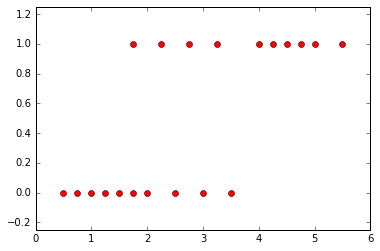

In [79]:
plt.plot ( hours, passfail, 'ro' )
plt.gca().set_ylim([-0.25,1.25])
plt.show()

In [101]:
(predict, predict_noclamp) = logisticRegression ( hours, passfail, 1000 )

Final model:
[ 1.2243251]
-3.29839387068
target values for D:
[0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
prediction on D:
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


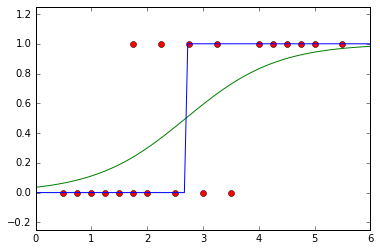

In [104]:
hours_hirez = np.reshape( np.linspace( 0, 6, 100 ), (-1, 1) )
plt.plot ( hours, passfail, 'ro', 
           hours_hirez, predict_noclamp( hours_hirez), "g-", 
           hours_hirez, predict (hours_hirez) )
plt.gca().set_ylim([-0.25,1.25])
plt.show()